In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import warnings
import sys
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

# open data files for each neuron and create population matrix
# randomly select mintrial per condition for each neuron


# here DEFINE THE PATH TO YOUR DATA
pathroot = '/media/nicolascatz/4d767acb-7d35-42a5-b630-86a61f8774d0/nicolascatz/DATA/Projets/EMN_MLP_NC/'
# pathroot = 'D:/DATA/Projet_SPIKE_Cluster_GBJNC/Script_pour_figures/'

pathdata = pathroot + '/data'
pathout= pathroot + '/out'

Neuronpop=np.load(pathdata + f'/Neuronpop_0.npz', allow_pickle=True)


2025-11-05 15:13:59.899386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 15:14:01.004515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 15:14:01.005306: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Preparation of the data for classification

In [3]:

mintrial=100
onset=100
offset=150
Unitpop=[]
for neuron in range(len(Neuronpop)):

    sua=Neuronpop[f'arr_{neuron}']
    
    Unit2r=random.sample(sua[sua[:,0]==2].tolist(), mintrial)
    Unit3r=random.sample(sua[sua[:,0]==3].tolist(), mintrial)
    Unit4r=random.sample(sua[sua[:,0]==4].tolist(), mintrial)
    Unit5r=random.sample(sua[sua[:,0]==5].tolist(), mintrial)

    Unit=np.concatenate((Unit2r,Unit3r,Unit4r,Unit5r), axis=0)

    UnitTime=np.sum(Unit[:,onset:offset], axis=1)
    UnitTime[UnitTime>0]=1
    #UnitTime[np.isnan(UnitTime)] = 0 # pas sur de celle la mais sinon ça ne marche pas je pige pas pourquoi il y a des NaN
    
    Unitpop.append(UnitTime)

StimTarget=Unit[:,0]
StimTarget=np.reshape(StimTarget, (400,1))
Unitpop=np.transpose(Unitpop)
#os.chdir('D:/DATA/Projet_SPIKE_Cluster_GBJNC/Script_pour_figures/')

Classification with a simple KNN

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Cross-validation for KNN to evaluate model performance more robustly


# Perform cross-validation with different k values
cv_scores = []
k_range = range(1, 31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='jaccard')
    scores = cross_val_score(knn, Unitpop, StimTarget.ravel(), cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best k value
best_k_cv = k_range[np.argmax(cv_scores)]
best_score_cv = max(cv_scores)

print(f'Best k from CV: {best_k_cv}')
print(f'Best CV accuracy: {best_score_cv*100:.2f}%')

X_train, X_test, y_train, y_test = train_test_split(Unitpop, StimTarget, test_size=0.2, random_state=10)

model = KNeighborsClassifier(n_neighbors=best_k_cv, metric='jaccard')
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print(f'KNN Accuracy: {accuracy*100:.2f}%')

Best k from CV: 29
Best CV accuracy: 62.75%
KNN Accuracy: 61.25%


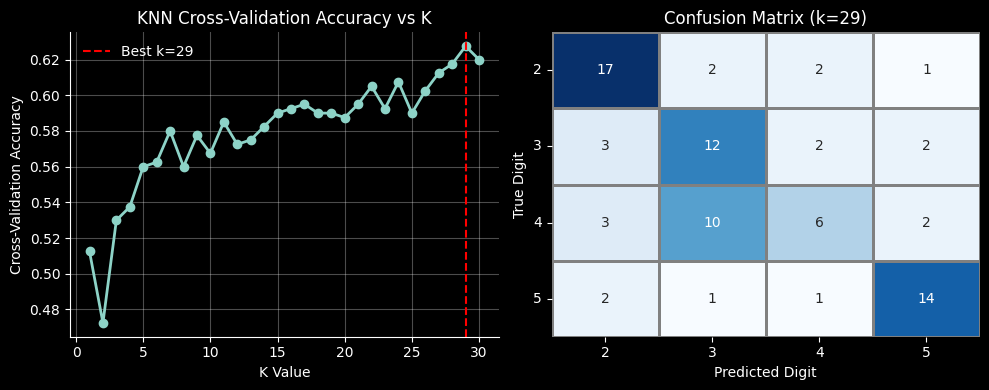

In [7]:
# Plot confusion matrix and training history from cross-validation results

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot CV scores vs k
ax[0].plot(k_range, cv_scores, marker='o', linestyle='-', linewidth=2)
ax[0].set_xlabel('K Value')
ax[0].set_ylabel('Cross-Validation Accuracy')
ax[0].set_title('KNN Cross-Validation Accuracy vs K')
ax[0].grid(True, alpha=0.3)
ax[0].axvline(x=best_k_cv, color='r', linestyle='--', label=f'Best k={best_k_cv}')
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot confusion matrix for best model
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1], linewidths=1, linecolor='gray')
ax[1].set_xticklabels(['2','3','4','5'])
ax[1].set_yticklabels(['2','3','4','5'], rotation=0)
ax[1].set_xlabel('Predicted Digit')
ax[1].set_ylabel('True Digit')
ax[1].set_title(f'Confusion Matrix (k={best_k_cv})')

plt.tight_layout()
plt.show()

Classification with a perceptron for N neurons and 2 classes


Accuracy: 0.72


Text(0.5, 1.0, 'Perceptron Confusion Matrix')

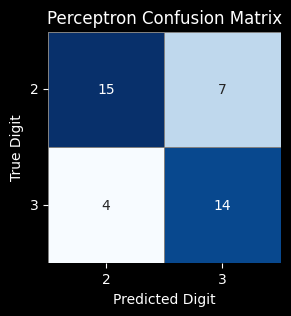

In [8]:
## perceptron for N neurons and 2 classes
### using sklearn Perceptron

from sklearn.linear_model import Perceptron

Nneurons=np.shape(Unitpop)[1]

X=Unitpop[0:200,0:Nneurons]

y=StimTarget[0:200]-2 # to have labels 0,1,2,3 instead of 2,3,4,5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and train the Perceptron model
perceptron = Perceptron(random_state=0)
perceptron.fit(X_train, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,linewidths=0.5, linecolor='gray')
ax.set_xticklabels(['2','3'])
ax.set_yticklabels(['2','3'], rotation=0)
ax.set_xlabel('Predicted Digit')
ax.set_ylabel('True Digit')
ax.set_title('Perceptron Confusion Matrix')


Perceptron for N neurons and 4 classes


In [9]:
## MLP for N neurons and 4 classes

Nneurons=np.shape(Unitpop)[1]

X=Unitpop[:,0:Nneurons]

y=StimTarget-2 # to have labels 0,1,2,3 instead of 2,3,4,5

AccScore_MLP=[]
CM_NN=np.zeros((4,4))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=0)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100,verbose=0)

history = model.history.history
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
AccScore_MLP.append(accuracy_score(y_test, y_pred))

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
accuracy = accuracy * 100
print(f'Test accuracy: {accuracy:.2f}%')
print(f'loss: {loss:.4f}')

cm=confusion_matrix(y_test, y_pred)


E0000 00:00:1762352069.932792 2057790 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762352069.952058 2057790 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7125 - loss: 1.4559  
Test accuracy: 71.25%
loss: 1.4559


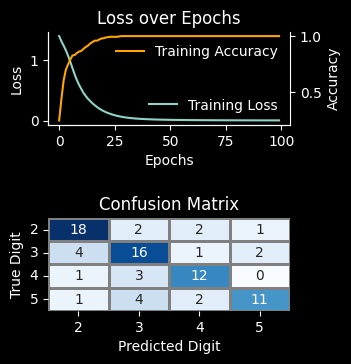

In [11]:

fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(history['loss'], label='Training Loss')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='lower right',frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax2 = ax[0].twinx()
ax2.plot(history['accuracy'], label='Training Accuracy', color='orange')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right',frameon=False)
ax2.spines['top'].set_visible(False)
sns.heatmap(cm, cmap='Blues', ax=ax[1], annot=True, fmt='d',cbar=False,linewidths=1, linecolor='gray')
ax[1].set_xticklabels(['2','3','4','5'])
ax[1].set_yticklabels(['2','3','4','5'], rotation=0)
ax[1].set_xlabel('Predicted Digit')
ax[1].set_ylabel('True Digit')
ax[1].set_title('Confusion Matrix')
plt.tight_layout(pad=2.0)
